## 1. Dataset Preparation

I use the UCI Adult Income dataset, clean missing values, and select features. The sensitive attribute used for fairness analysis is `sex`.


## 2. Model Training and Evaluation

I train a logistic regression model and evaluate it using accuracy, confusion matrix, and classification report.


In [9]:
# Install needed packages first (run once)
!pip install fairlearn shap lime --quiet

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load Adult Income dataset from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                'hours-per-week', 'native-country', 'income']

data = pd.read_csv(url, names=column_names, na_values=" ?", skipinitialspace=True)

# Drop rows with missing values
data = data.dropna()

# Select features and target
X = data.drop('income', axis=1)
y = data['income'].apply(lambda x: 1 if x == '>50K' else 0)  # binary target

# Select sensitive attribute for fairness analysis
sensitive_feature = X['sex']

# Encode categorical features
categorical_cols = X.select_dtypes(include='object').columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5


## 3. Fairness Analysis with Fairlearn

I compute selection rate, false positive rate, and true positive rate across groups defined by the sensitive attribute (`sex`).


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train/test split
X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42, stratify=y)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate performance
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)


Accuracy: 0.8056
Confusion Matrix:
[[7031  386]
 [1513  839]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      7417
           1       0.68      0.36      0.47      2352

    accuracy                           0.81      9769
   macro avg       0.75      0.65      0.68      9769
weighted avg       0.79      0.81      0.78      9769



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


        selection_rate  false_positive_rate  true_positive_rate
sex                                                            
Female        0.046890             0.023935            0.229050
Male          0.163623             0.069493            0.379639


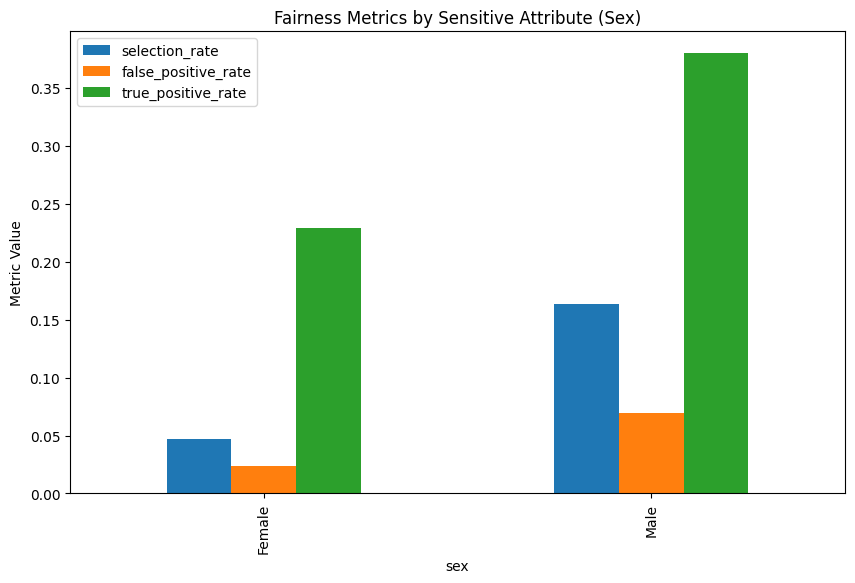

In [11]:
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import matplotlib.pyplot as plt

# Define metrics
metrics = {
    'selection_rate': selection_rate,
    'false_positive_rate': false_positive_rate,
    'true_positive_rate': true_positive_rate
}

# Create MetricFrame to compute metrics by sensitive groups (sex)
metric_frame = MetricFrame(metrics=metrics,
                          y_true=y_test,
                          y_pred=y_pred,
                          sensitive_features=sens_test)

print(metric_frame.by_group)

# Plot fairness metrics
metric_frame.by_group.plot.bar(figsize=(10,6))
plt.title("Fairness Metrics by Sensitive Attribute (Sex)")
plt.ylabel("Metric Value")
plt.show()


## 4. Explainability with SHAP

I use SHAP to understand which features influence the model globally (summary plot) and locally (waterfall plot).


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


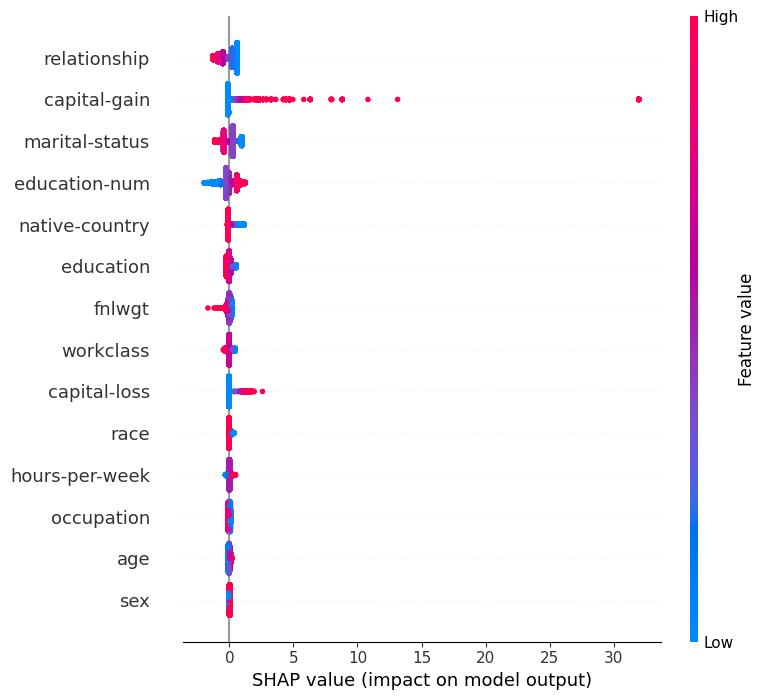

In [12]:
import shap

# Updated argument name
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

# Global summary plot
shap.summary_plot(shap_values, X_test)


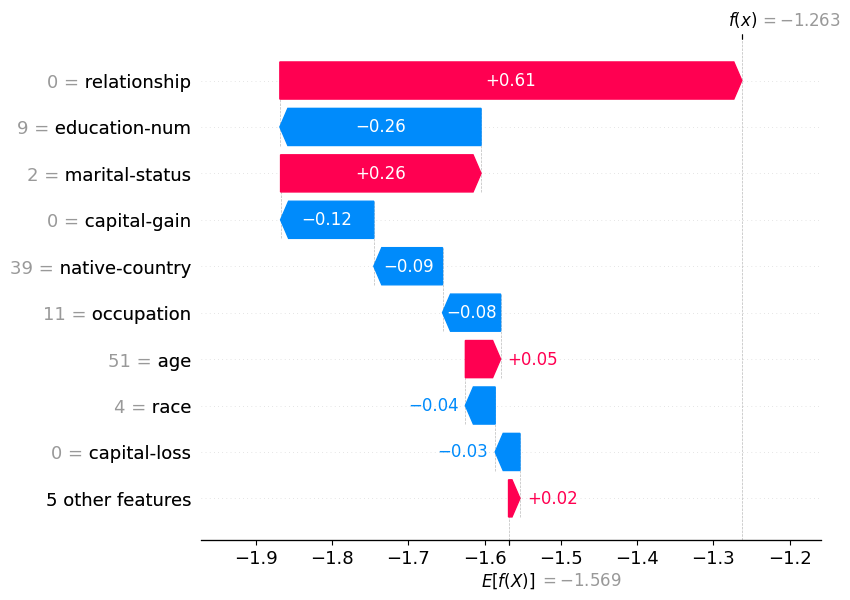

In [13]:
# Use SHAP Explanation object for one instance
idx = 0  # choose any index
shap.waterfall_plot(shap.Explanation(values=shap_values[idx],
                                     base_values=explainer.expected_value,
                                     data=X_test.iloc[idx],
                                     feature_names=X_test.columns))


## 5. Explainability with LIME

I apply LIME to explain a single prediction using an interpretable surrogate model.


In [14]:
import lime
import lime.lime_tabular
import numpy as np

# Create LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['<=50K', '>50K'],
    mode='classification'
)


In [15]:
# Select the same index as in SHAP
instance_idx = 0

# Explain instance
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[instance_idx],
    predict_fn=model.predict_proba
)


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

## 6. Summary and Conclusion

This notebook demonstrates the importance of fairness and explainability in machine learning. We identified potential biases, visualized fairness metrics, and explained model decisions using SHAP and LIME.
